# WeRateDogs Twitter Archive Analysis
<img src="./img/header.jpeg" alt="header" style="display:block; margin:auto;">

Photo by [WeRateDogs®](https://twitter.com/dog_rates?s=20)

In [1]:
# Importing modules
import numpy as np
import pandas as pd
import tweepy
import json
from scipy import stats
import collections
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rcParams
import seaborn as sns
import requests
from IPython.display import display
import os
import glob
import inspect

# magic commands
%matplotlib inline

## 1. Introduction

[WeRateDogs](https://en.wikipedia.org/wiki/WeRateDogs) is a Twitter account that rates people's dogs with a humorous comment about the dog. As this one here:

<img src="./img/dog.png" alt="Funny tweet" width="400" height="400" style="display:block; margin:auto;"> 

This analysis explores a dataset containing WeRateDogs's Twitter archive covering the period from November 2015 to August 2017.

## 2. Data Gathering

### **2.1.** Problem Statement

The report aims to:

1. Describe time trends of WeRateDogs® Twitter account activity.
2. Explore the effect of rating on likes and retweets.
3. Determine the most popular dog breeds.

### **2.2.** Datasets

Data is spread between three sources:

1. Twitter archive data that WeRateDogs downloaded and sent to the Udacity team, which parsed the data and stored it in `twitter_archive_enhanced.csv` file. This file was downloaded manually from [here](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv).
2. The dogs' breed predictions were based on the tweet's image(s), which was performed by Udacity team using a neural network, and was stored in `image_predictions.tsv` file. This file will be downloaded using [Requests](https://pypi.org/project/requests/) library and this [URL](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv).
3. Additional data (retweet count - reply count - like count - quote count) will be gathered from Twitter's API and stored in `tweet_json.txt` file.

#### **Dataset 1 - WeRateDogs® Twitter Archive Data**

Type: CSV File

Method: Manual download from this [link](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv)

Dataset variables:
- tweet_id
- in_reply_to_status_id
- in_reply_to_user_id
- timestamp
- source
- text
- retweeted_status_id
- retweeted_status_user_id
- retweeted_status_timestamp
- expanded_urls
- rating_numerator
- rating_denominator
- name
- doggo
- floofer
- pupper
- puppo

In this dataset, `tweet_id` is the key column to perform joins, `timestamp` is the primary column to explore timetrends in the account activity, and `rating_numerator` is the main explanatory variable that affects number of likes and retweets. 

Since `rating_denominator` is always 10 in WeRateDogs rating system, it doesn't provide any usefull information.

The last four variables represent dog stages in WeRateDogs rating system.

In [2]:
# Load the 'twitter-archive-enhanced.csv' into a Pandas DataFrame
archive_data = pd.read_csv('./datasets/twitter-archive-enhanced.csv')

#### **Dataset 2 - Image Predictions File**

Type: TSV File

Method: Programmatic Download using Requests Library

Dataset variables:

- tweet_id
- jpg_url
- img_num
- p1
- p1_conf
- p1_dog
- p2
- p2_conf
- p2_dog
- p3
- p3_conf
- p3_dog

Udacity team ran every image in the WeRateDogs Twitter archive through a neural network that can classify breeds of dogs. The dataset includes the predictions of three algorithms `p1`,`p2`,`p3`; thier confidence; and whether whether or not the prediction is a breed of dog. 

I mainly care about `p1` in this dataset, since this is the most confident prediction. `tweet_id` is the key column to perform joins.

In [3]:
# Use requests library to download 'image-predictions.tsv'
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
with open('./datasets/image-predictions.tsv', 'wb') as f:
    f.write(r.content)
# Load the 'image-predictions.tsv' into a Pandas DataFrame    
img_pred = pd.read_csv('./datasets/image-predictions.tsv', sep='\t')

#### **Dataset 3 - Additional Data via the Twitter API**

Type: TXT File

Method: Query Twitter API

Dataset variables:

- tweet_id
- timestamp
- text
- retweet_count
- reply_count
- like_count
- quote_count

This third dataset contains additional data for every tweet in the first dataset (WeRateDogs® Twitter Archive Data). `tweet_id` is the key column to perform joins, `timestamp` is the primary column to explore timetrends in the account activity, `like_count` and `retweet_count` are the response variables for the second research question of this report. 

In [4]:
# Loading keys from 'keys.py'
from keys import *
# Using OAuth 1.0a User Context to access Twitter API v2
client = tweepy.Client( bearer_token=bearer_token, 
                        consumer_key=consumer_key, 
                        consumer_secret=consumer_secret, 
                        access_token=access_token, 
                        access_token_secret=access_token_secret, 
                        return_type = requests.Response,
                        wait_on_rate_limit=True)

In [5]:
""" 
# Due to Twitter's API Rate Limit, this cell takes VERY long time to run
# Please remove the block comment in order to run this cell

# Query Twitter API v2 for each tweet's JSON data, and save to 'tweet_json.txt'
with open('./datasets/tweet_json.txt', 'w') as f:
    for _id in archive_data.tweet_id.values:
        try:
            tweet = client.get_tweet(_id, tweet_fields=["created_at", "public_metrics"]).json()
            f.write(json.dumps(tweet['data']))
            f.write('\n')
        except Exception:
            continue 
"""

' \n# Due to Twitter\'s API Rate Limit, this cell takes VERY long time to run\n# Please remove the block comment in order to run this cell\n\n# Query Twitter API v2 for each tweet\'s JSON data, and save to \'tweet_json.txt\'\nwith open(\'./datasets/tweet_json.txt\', \'w\') as f:\n    for _id in archive_data.tweet_id.values:\n        try:\n            tweet = client.get_tweet(_id, tweet_fields=["created_at", "public_metrics"]).json()\n            f.write(json.dumps(tweet[\'data\']))\n            f.write(\'\n\')\n        except Exception:\n            continue \n'

In [6]:
# Reading 'tweet_json.txt' line by line and append it to 'api_data_list' 
api_data_list = []
for line in open('./datasets/tweet_json.txt', 'r'):
    tweet = json.loads(line)
    api_data_list.append(
                        {'tweet_id': tweet['id'],
                        'timestamp': tweet['created_at'],
                        'text': tweet['text'],
                        'retweet_count': tweet['public_metrics']['retweet_count'],
                        'reply_count': tweet['public_metrics']['reply_count'],
                        'like_count': tweet['public_metrics']['like_count'],
                        'quote_count': tweet['public_metrics']['quote_count']}
                        )
    
# Create a new DataFrame for API data
columns = ['tweet_id', 'timestamp', 'text', 'retweet_count', 'reply_count', 'like_count', 'quote_count']
api_data = pd.DataFrame(api_data_list, columns = columns)

## 2. Assess data

### Visual Assessment

> Data is displayed in both the Notebook and JupyterLab text editor for visual assessment.

In [7]:
display(archive_data)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [8]:
display(img_pred)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [9]:
display(api_data)

,tweet_id,timestamp,text,retweet_count,reply_count,like_count,quote_count
0,892420643555336193,2017-08-01T16:23:56.000Z,This is Phineas. He's a mystical boy. Only eve...,6822,135,32678,219
1,892177421306343426,2017-08-01T00:17:27.000Z,This is Tilly. She's just checking pup on you....,5136,162,28245,274
2,891815181378084864,2017-07-31T00:18:03.000Z,This is Archie. He is a rare Norwegian Pouncin...,3392,108,21210,145
3,891689557279858688,2017-07-30T15:58:51.000Z,This is Darla. She commenced a snooze mid meal...,7036,139,35627,286
4,891327558926688256,2017-07-29T16:00:24.000Z,This is Franklin. He would like you to stop ca...,7552,192,34034,296
...,...,...,...,...,...,...,...
2321,666049248165822465,2015-11-16T00:24:50.000Z,Here we have a 1949 1st generation vulpix. Enj...,36,9,85,0
2322,666044226329800704,2015-11-16T00:04:52.000Z,This is a purebred Piers Morgan. Loves to Netf...,111,1,241,2
2323,666033412701032449,2015-11-15T23:21:54.000Z,Here is a very happy pup. Big fan of well-main...,35,1,97,0
2324,666029285002620928,2015-11-15T23:05:30.000Z,This is a western brown Mitsubishi terrier. Up...,39,0,110,0


### Programmatic Assessment
#### `archive_data` table

In [10]:
# High level overview of the dataset
print('\033[1m archive_data info: \033[0m')
print(archive_data.info())

 archive_data info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo       

In [11]:
# Summary statistics
print('\033[1m archive_data statistical summary: \033[0m')
display(archive_data.describe())

 archive_data statistical summary: 


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [12]:
# Check for null values
print('\033[1m archive_data null values: \033[0m')
print(archive_data.isnull().sum())

 archive_data null values: 
tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64


In [13]:
# Check for duplicates
print(f'\033[1m archive_data duplicates \033[0m = {archive_data.duplicated().sum()}')

 archive_data duplicates  = 0


In [14]:
# Check for invalid values of `rating_denominator`
print(f"Number of invalid values of rating_denominator: {archive_data.query('rating_denominator != 10').shape[0]}")

Number of invalid values of rating_denominator: 23


In [15]:
# Change Pandas max string legnth
pd.set_option('display.max_colwidth', 255)
# Visual assessment of `text` for these values
unusual_numerator = archive_data.query('rating_denominator != 10').text
print(f'\033[1m Rows with unusual numerator: \033[0m\n {unusual_numerator}')

 Rows with unusual numerator: 
 313                                                                            @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
342                                                                                                                                      @docmisterio account started on 11/15/15
433                                                                           The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
516     Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
784                                  RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…
902                                                                           

In [16]:
# Find `rating_numerator` largest 10 values for visual comparision with `text`
large_numerator = archive_data.rating_numerator.sort_values(ascending=False)[:10]
print(f'\033[1m Rows with very large numerator: \033[1m\n{large_numerator}')

 Rows with very large numerator: 
979     1776
313      960
189      666
188      420
2074     420
1120     204
290      182
902      165
1779     144
1634     143
Name: rating_numerator, dtype: int64


In [17]:
# Extract ratings from `text`
print(archive_data.text.iloc[large_numerator.index])

979                                                            This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
313                                        @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
189     @s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10
188                                                    @dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research
2074                                                      After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY
1120                Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
290                                                                                                                        @markhoppus 182/10
902   

>***Denominator***

**Values to be changed to 10**: 313, 784, 1068, 1165, 1202, 1662, 2335

**Valid values**: 433, 902, 1120, 1228, 1254, 1274, 1351, 1433, 1598, 1634, 1635, 1663, 1779, 1843

**Values to be removed**: 342, 516

>***Numerator***

**Values to be changed**: 313, 784, 1068, 1165, 1202, 1662, 2335

**Valid values**: 433, 902, 1120, 1228, 1254, 1274, 1351, 1433, 1598, 1634, 1635, 1663, 1779, 1843

In [18]:
# Check for invalid `name` values (articles)
article_names = archive_data.query('name == "a" or name == "an" or name == "the"')
print(f"number of articles mistaken for dog's name: {article_names.shape[0]}")

number of articles mistaken for dog's name: 70


In [19]:
# Check for other names with less than 3 letters
short_names = archive_data[(archive_data['name'].agg(len)) <= 3]
short_not_articles = short_names[~short_names.index.isin(article_names.index)]

# set display options to show all rows
pd.options.display.max_rows = None
display(short_not_articles['name'])

# reset all display options to defaults
pd.reset_option('display.max_rows')

6       Jax
13      Ted
16      Jim
49      Gus
53      Rey
77      Aja
92      Jed
217     Leo
266     Ken
270     Max
304     Ava
308     Eli
311     Ash
319     Leo
335     not
360     Mia
361     Leo
366     Gus
369     one
392     Ike
393      Mo
446      Bo
449      Bo
454     Tom
463     Ken
486     Alf
491     Sky
503     Tyr
510     Moe
511     Ted
516     Sam
520     Gus
526     Ito
553      Bo
582     Doc
583      Bo
613     Tyr
673     Eli
679      Bo
682     mad
685     Leo
686      Bo
708     Doc
752     Jay
755     Mya
775       O
820      Al
831     Lou
852      my
860     Eve
876      Bo
917     Jax
924     one
930     Dex
938     Ace
957     Max
966     Zoe
976     Jax
978      Bo
984     Blu
988     not
992     his
993     one
1028    Gus
1062    Ted
1064    Leo
1095    mad
1105    Jax
1138    all
1179    Sid
1206    old
1329    Max
1430    Ole
1455    Bob
1509    Leo
1633    Obi
1674    Jax
1683     Bo
1724     by
1741    Evy
1755    Tug
1756    Mia
1809    Ash
1879

Beside articles mistaken for the dog's name, two additional wrong names were discovered (indexs 775 and 1724)

In [20]:
# `source` values, no apparent problem
print(archive_data.source.value_counts())

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64


#### `img_pred` table

In [21]:
# High level overview of the dataset
print('\033[1m img_pred info: \033[0m')
print(img_pred.info())

 img_pred info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB
None


In [22]:
# Summary statistics, no apparent problems
print('\033[1m Statistical Summary of img_pred\n\033[0m')
img_pred.describe()

 Statistical Summary of img_pred



,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [23]:
# Check for null values
print('\033[1m img_pred null values: \033[0m')
print(img_pred.isnull().sum())

 img_pred null values: 
tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64


In [24]:
# Check for duplicates
print(f'\033[1m img_pred duplicates \033[0m = {img_pred.duplicated().sum()}')

 img_pred duplicates  = 0


#### `api_data` table

In [25]:
# High level overview of the dataset
print('\033[1m api_data info: \033[0m')
print(api_data.info())

 api_data info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2326 entries, 0 to 2325
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet_id       2326 non-null   object
 1   timestamp      2326 non-null   object
 2   text           2326 non-null   object
 3   retweet_count  2326 non-null   int64 
 4   reply_count    2326 non-null   int64 
 5   like_count     2326 non-null   int64 
 6   quote_count    2326 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 127.3+ KB
None


In [26]:
# Summary statistics, no apparent problems
print('\033[1m Statistical Summary of api_data\n\033[0m')
api_data.describe()

 Statistical Summary of api_data



,retweet_count,reply_count,like_count,quote_count
count,2326.000000,2326.000000,2326.000000,2326.000000
mean,2405.193895,41.206363,6816.897248,71.597592
std,4071.920012,69.150000,10591.464377,220.422690
min,0.000000,0.000000,0.000000,0.000000
25%,482.500000,9.000000,1186.000000,0.000000
50%,1117.000000,23.000000,2952.500000,1.000000
75%,2783.750000,47.000000,8333.250000,69.750000
max,68821.000000,1097.000000,140568.000000,4352.000000


In [27]:
# Check for null values
print('\033[1m api_data null values: \033[0m')
print(api_data.isnull().sum())

 api_data null values: 
tweet_id         0
timestamp        0
text             0
retweet_count    0
reply_count      0
like_count       0
quote_count      0
dtype: int64


In [28]:
# Check for duplicates
print(f'\033[1m api_data duplicates \033[0m = {api_data.duplicated().sum()}')

 api_data duplicates  = 0


### Quality issues
#### `archive_data` table
- Table contains retweets. Analysis is based on original tweets only.
- Table contains replies. Analysis is based on original tweets only.
- Erroneous datatypes (`tweet_id`,`timestamp`)Erroneous datatypes (`tweet_id`,`timestamp`)
- Invalid values in `rating_denominator` column
- Invalid values in `rating_numerator` column
- Invalid values in `name` column
- 14 rows have more than one dog stage (discovered during cleaning)
- Missing values in `expanded_urls`

#### `img_pred` table
- Erroneous datatype (`tweet_id`)

#### `api_data` table
- Erroneous datatype (`timestamp`)

### Tidiness issues
#### `archive_data` table
- Four columns: `doggo`, `floofer`, `pupper`, `puppo` represent one variable `dog_stage`

#### `img_pred` table
- This table's data should be part of `archive_data` table

#### `api_data` table
- This table's data should be part of `archive_data` table

## 3. Clean data

> All cleaning steps will be performed done using (Define - Code - Test) framework. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

> Before cleaning I'm making a copy of the original data.

In [29]:
# Make copies of original pieces of data
archive_data_clean = archive_data.copy()
img_pred_clean = img_pred.copy()
api_data_clean = api_data.copy()

### Issue 1 - Erroneous datatypes in all tables

#### Define:
Change erronous dtypes using `.astype` method. Create a function to automate the process for future use.

The reason for applying `'string'` dtype to `'tweet_id'` column in all three tables is that I discoverred that some of them have leading or trailing white spaces. By converting them to 'string' dtype they can be stripped of these white spaces using `.str.strip()` method.

#### Code

In [30]:
# Create a function to automate the process
def ChangeDtype(df, cols_dtypes):
    '''
    Change a DataFrame column(s) dtype
    
    Args:
        df: Pandas DataFrame (Dataframe)
        cols_dtypes: Dictionary. 
                      Keys are columns to change their dtype. 
                      Values are the new dtypes.
    
    Returns:
        None
    '''
    for col, dtype in cols_dtypes.items():
        df[col] = df[col].astype(dtype)

In [31]:
# Create dicts for columns to change in every table
archive_data_dict = {'tweet_id':'string', 'timestamp':'datetime64[ns]'}
img_pred_dict = {'tweet_id':'string'}
api_data_dict = {'tweet_id':'string', 'timestamp':'datetime64[ns]'}

# Change to correct dtypes
ChangeDtype(archive_data_clean, archive_data_dict)
ChangeDtype(img_pred_clean, img_pred_dict)
ChangeDtype(api_data_clean, api_data_dict)

#### Test

In [32]:
assert archive_data_clean['tweet_id'].dtype == 'string'
assert archive_data_clean['timestamp'].dtype == 'datetime64[ns]'
assert img_pred_clean['tweet_id'].dtype == 'string'
assert api_data_clean['timestamp'].dtype == 'datetime64[ns]'

### Issue 2 - `rating_denominator` column has invalid values in `archive_data` table

#### Define:
Replace invalid values in `rating_denominator` column with 10, using `replace` method.

#### Code

In [33]:
# Values to be changed to 10
archive_data_clean.loc[[313, 784, 1068, 1165, 1202, 1662, 2335],'rating_denominator'] = 10

#### Test

In [34]:
print(archive_data_clean['rating_denominator'].value_counts())

10     2340
80        2
50        2
15        1
70        1
7         1
150       1
170       1
90        1
40        1
20        1
130       1
110       1
16        1
120       1
Name: rating_denominator, dtype: int64


### Issue 3 - `rating_numerator` column has invalid values in `archive_data` table

#### Define:
Replace invalid values in `rating_denominator` column with correct one in `text`, using `replace` method.

#### Code

In [35]:
# Change `rating_numerator` values
archive_data_clean.loc[2335,'rating_numerator'] = 9
archive_data_clean.loc[1662,'rating_numerator'] = 10
archive_data_clean.loc[1202,'rating_numerator'] = 11
archive_data_clean.loc[[313,1165],'rating_numerator'] = 13
archive_data_clean.loc[[784,1068],'rating_numerator'] = 14

#### Test

In [36]:
print(archive_data_clean['rating_numerator'].value_counts())

12      558
11      465
10      462
13      353
9       157
8       102
14       56
7        54
5        37
6        32
3        19
4        16
2         9
1         8
75        2
0         2
15        2
420       2
45        1
144       1
17        1
26        1
20        1
121       1
143       1
44        1
60        1
99        1
80        1
84        1
204       1
1776      1
165       1
666       1
27        1
182       1
24        1
88        1
Name: rating_numerator, dtype: int64


### Issue 4 - Invalid values in `name` column of `archive_data` table

#### Define:
Replace invalid values in `name` column with `np.nan`, using `replace` method.

#### Code

In [37]:
# Remove articles mistaken for the name
archive_data_clean['name'] = archive_data_clean['name'].replace(['a', 'an', 'the'], np.nan)
# Remove two additional invalid values
archive_data_clean.loc[[775,1724], 'name'] = np.nan

#### Test

In [38]:
assert archive_data_clean.query('name == "a" or name == "an" or name == "the"').shape[0] == 0
assert archive_data_clean.loc[[775, 1724], 'name'].isna().all() == True

### Issue 5 - Four columns: `doggo`, `floofer`, `pupper`, `puppo` represent one variable `dog_stage`

#### Define:
Replace `None` values with empty strings, then combine the four columns using string concatenation to create `dog_stage` column. Finally, drop the four columns and replace empty strings in `dog_stage` with `None`.

#### Code

In [39]:
# Convert `None` values to ``
stage_cols = ['doggo', 'floofer', 'pupper', 'puppo']
archive_data_clean[stage_cols] = archive_data_clean[stage_cols].replace('None', '')
# Combine the four columns into `dog_stage` column
archive_data_clean['dog_stage'] = archive_data_clean.doggo + archive_data_clean.floofer + archive_data_clean.pupper + archive_data_clean.puppo
# Drop the four columns
archive_data_clean.drop(stage_cols, axis=1, inplace=True)
# Convert `` values to NaN in `dog_stage` column
archive_data_clean['dog_stage']  = archive_data_clean['dog_stage'].replace('', 'None')

#### Test

In [40]:
assert 'dog_stage' in archive_data_clean.columns
assert archive_data_clean['dog_stage'].isna().sum() == 0
print(archive_data_clean['dog_stage'].value_counts())

None            1976
pupper           245
doggo             83
puppo             29
doggopupper       12
floofer            9
doggopuppo         1
doggofloofer       1
Name: dog_stage, dtype: int64


### Issue 6 - Rows with multiple `dog_stage` values in `archive_data` table

#### Define:
Reassess the new `dog_stage` column, compare the values visually with `text`, and change them accordingly.

#### Code

In [41]:
# Reassessment: review `text` for visual assessment of these rows
print(archive_data_clean.query('dog_stage == "doggopupper" or dog_stage == "doggopuppo" or dog_stage == "doggofloofer"').text)

191           Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel
200     At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk
460     This is Dido. She's playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7
531                         Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho
565                                                                                                    Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze
575                         This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper ever

In [42]:
# Change inacurate 'dog_stage' values
archive_data_clean.loc[191, 'dog_stage'] = 'puppo'
archive_data_clean.loc[200,'dog_stage'] = 'floofer'
archive_data_clean.loc[705,'dog_stage'] = 'doggo'
archive_data_clean.loc[[460,575],'dog_stage'] = 'pupper'
archive_data_clean.loc[956,'dog_stage'] = 'None'
archive_data_clean.loc[[531,565,733,778,822,889,1063,1113],'dog_stage'] = 'pupper&doggo'

#### Test

In [43]:
print(archive_data_clean.dog_stage.value_counts())

None            1977
pupper           247
doggo             84
puppo             30
floofer           10
pupper&doggo       8
Name: dog_stage, dtype: int64


### Issue 7 - `archive_data` table contains replies

#### Define:
Remove rows with non-null values in `in_reply_to_status_id` and `in_reply_to_user_id` columns.

#### Code

In [44]:
# Keep only rows that are not replies
archive_data_clean = archive_data_clean[pd.isnull(archive_data_clean['in_reply_to_status_id'])]
archive_data_clean = archive_data_clean[pd.isnull(archive_data_clean['in_reply_to_user_id'])]

#### Test

In [45]:
assert archive_data_clean['in_reply_to_status_id'].isna().sum() == archive_data_clean.shape[0]
assert archive_data_clean['in_reply_to_user_id'].isna().sum() == archive_data_clean.shape[0]

### Issue 8 - `archive_data` table contains retweets

#### Define:
Remove rows with non-null values in `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` columns.

#### Code

In [46]:
# Keep only rows that are not retweets
archive_data_clean = archive_data_clean[pd.isnull(archive_data_clean['retweeted_status_id'])]
archive_data_clean = archive_data_clean[pd.isnull(archive_data_clean['retweeted_status_user_id'])]
archive_data_clean = archive_data_clean[pd.isnull(archive_data_clean['retweeted_status_timestamp'])]

#### Test

In [47]:
assert archive_data_clean['retweeted_status_id'].isna().sum() == archive_data_clean.shape[0]
assert archive_data_clean['retweeted_status_user_id'].isna().sum() == archive_data_clean.shape[0]
assert archive_data_clean['retweeted_status_timestamp'].isna().sum() == archive_data_clean.shape[0]

### Issue 9 - Reply and retweet data columns are not needed

#### Define:
Drop `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` columns from `archive_data_clean` DataFrame; since they are now all null values and the analysis require only the original tweets.

#### Code

In [48]:
# drop reply and retweet columns
del_cols = ['in_reply_to_status_id','in_reply_to_user_id', 'retweeted_status_id','retweeted_status_user_id', 'retweeted_status_timestamp']
archive_data_clean.drop(del_cols, axis=1, inplace=True)

#### Test

In [49]:
for col in del_cols:
    assert col not in archive_data_clean.columns

### Issue 10 - `api_data` should be part of `archive_data` table

#### Define:
Merge `retweet_count`, `reply_count`, `like_count`, `quote_count` columns to `archive_data` table using `merge` function with an inner join. This will update the DataFrame with Twitter API data.

#### Code

In [50]:
# Remove any possible white spaces in 'tweet_id' columns
archive_data_clean['tweet_id'] = archive_data_clean['tweet_id'].str.strip()
api_data_clean['tweet_id'] = api_data_clean['tweet_id'].str.strip()
img_pred_clean['tweet_id'] = img_pred_clean['tweet_id'].str.strip()

In [51]:
# Inner join archive_data and api_data
master_df = archive_data_clean.merge(api_data_clean, on=['tweet_id', 'timestamp', 'text'])

#### Test

In [52]:
print(master_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2089 entries, 0 to 2088
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2089 non-null   string        
 1   timestamp           2089 non-null   datetime64[ns]
 2   source              2089 non-null   object        
 3   text                2089 non-null   object        
 4   expanded_urls       2086 non-null   object        
 5   rating_numerator    2089 non-null   int64         
 6   rating_denominator  2089 non-null   int64         
 7   name                2018 non-null   object        
 8   dog_stage           2089 non-null   object        
 9   retweet_count       2089 non-null   int64         
 10  reply_count         2089 non-null   int64         
 11  like_count          2089 non-null   int64         
 12  quote_count         2089 non-null   int64         
dtypes: datetime64[ns](1), int64(6), object(5), strin

### Issue 11 - `img_pred` should be part of `archive_data` table

#### Define:
Merge `img_pred` columns to `archive_data` table using `merge` function with an inner join, leaving only tweets with images. ***This step will also remove rows with missing values in `expanded_urls`***.

#### Code

In [53]:
# Inner join master_df and img_pred
master_df = master_df.merge(img_pred_clean, on='tweet_id')

#### Test

In [54]:
print(master_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1963 entries, 0 to 1962
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1963 non-null   string        
 1   timestamp           1963 non-null   datetime64[ns]
 2   source              1963 non-null   object        
 3   text                1963 non-null   object        
 4   expanded_urls       1963 non-null   object        
 5   rating_numerator    1963 non-null   int64         
 6   rating_denominator  1963 non-null   int64         
 7   name                1893 non-null   object        
 8   dog_stage           1963 non-null   object        
 9   retweet_count       1963 non-null   int64         
 10  reply_count         1963 non-null   int64         
 11  like_count          1963 non-null   int64         
 12  quote_count         1963 non-null   int64         
 13  jpg_url             1963 non-null   object      

## 4. Reassess Data

In [55]:
display(master_df.head(2))

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,6822,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,5136,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [56]:
print(master_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1963 entries, 0 to 1962
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1963 non-null   string        
 1   timestamp           1963 non-null   datetime64[ns]
 2   source              1963 non-null   object        
 3   text                1963 non-null   object        
 4   expanded_urls       1963 non-null   object        
 5   rating_numerator    1963 non-null   int64         
 6   rating_denominator  1963 non-null   int64         
 7   name                1893 non-null   object        
 8   dog_stage           1963 non-null   object        
 9   retweet_count       1963 non-null   int64         
 10  reply_count         1963 non-null   int64         
 11  like_count          1963 non-null   int64         
 12  quote_count         1963 non-null   int64         
 13  jpg_url             1963 non-null   object      

In [57]:
print(master_df.isnull().sum())

tweet_id               0
timestamp              0
source                 0
text                   0
expanded_urls          0
rating_numerator       0
rating_denominator     0
name                  70
dog_stage              0
retweet_count          0
reply_count            0
like_count             0
quote_count            0
jpg_url                0
img_num                0
p1                     0
p1_conf                0
p1_dog                 0
p2                     0
p2_conf                0
p2_dog                 0
p3                     0
p3_conf                0
p3_dog                 0
dtype: int64


Note that missing values in 'name' column are the result of step 4 in cleaning data.

In [58]:
print(master_df.duplicated().sum())

0


In [59]:
display(master_df.describe())

,rating_numerator,rating_denominator,retweet_count,reply_count,like_count,quote_count,img_num,p1_conf,p2_conf,p3_conf
count,1963.000000,1963.000000,1963.000000,1963.00000,1963.000000,1963.000000,1963.000000,1963.000000,1.963000e+03,1.963000e+03
mean,12.217015,10.456954,2197.053490,44.29241,7492.294447,78.190015,1.202241,0.594066,1.346523e-01,6.026787e-02
std,41.708747,6.802856,3929.438088,71.61844,11038.795858,229.759900,0.559739,0.272135,1.009671e-01,5.097105e-02
min,0.000000,7.000000,11.000000,0.00000,62.000000,0.000000,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,10.000000,10.000000,486.000000,12.00000,1606.000000,0.000000,1.000000,0.362880,5.352315e-02,1.619495e-02
50%,11.000000,10.000000,1057.000000,25.00000,3380.000000,1.000000,1.000000,0.587372,1.174020e-01,4.947150e-02
75%,12.000000,10.000000,2511.500000,50.00000,9324.000000,81.500000,1.000000,0.847139,1.955655e-01,9.158675e-02
max,1776.000000,170.000000,68821.000000,1097.00000,140568.000000,4352.000000,4.000000,1.000000,4.880140e-01,2.734190e-01


## 5. Update Data Store

Save gathered, assessed, and cleaned master dataset to a CSV file named `"twitter_master.csv"`.

In [60]:
master_df.to_csv('./datasets/twitter_master.csv', index=False)

## 6. Answer the research question

The analysis in this section will be based on `master_df` Dataframe, which is now clean and in tidy format.

### **6.1:** Time trends of WeRateDogs account activity

The first point of this analysis is WeRateDogs account activity overtime.

#### Number of tweets per month

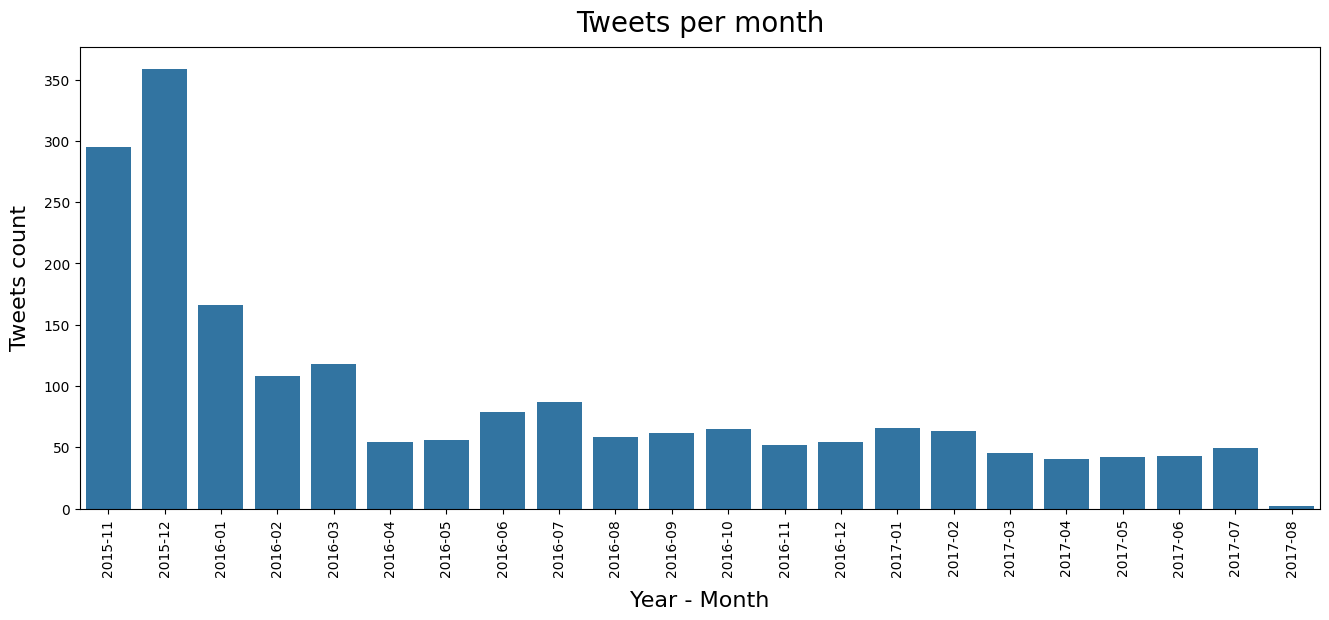

In [61]:
# Tweets number per month
rcParams['figure.figsize'] = 16,6
base_color = sns.color_palette()[0]
sns.countplot(data=master_df, x=master_df['timestamp'].sort_values().dt.to_period('M'), color = base_color);
plt.title('Tweets per month', fontsize=20, y=1.015)
plt.xlabel('Year - Month', labelpad=10, fontsize=16)
plt.ylabel('Tweets count', labelpad=10, fontsize=16)
# Use xticks to rotate the category labels (not axes) counter-clockwise
plt.xticks(rotation=90)
# Save to a file
plt.savefig('./img/tweets_per_month.png')
# Show the plot
plt.show();

This account was very active in the first two months of the dataset, activity dropped noticeably starting from the second quarter of 2016.

#### Active tweeting hours

**What about tweeting hours? Is this account more active in certain times of the day?**

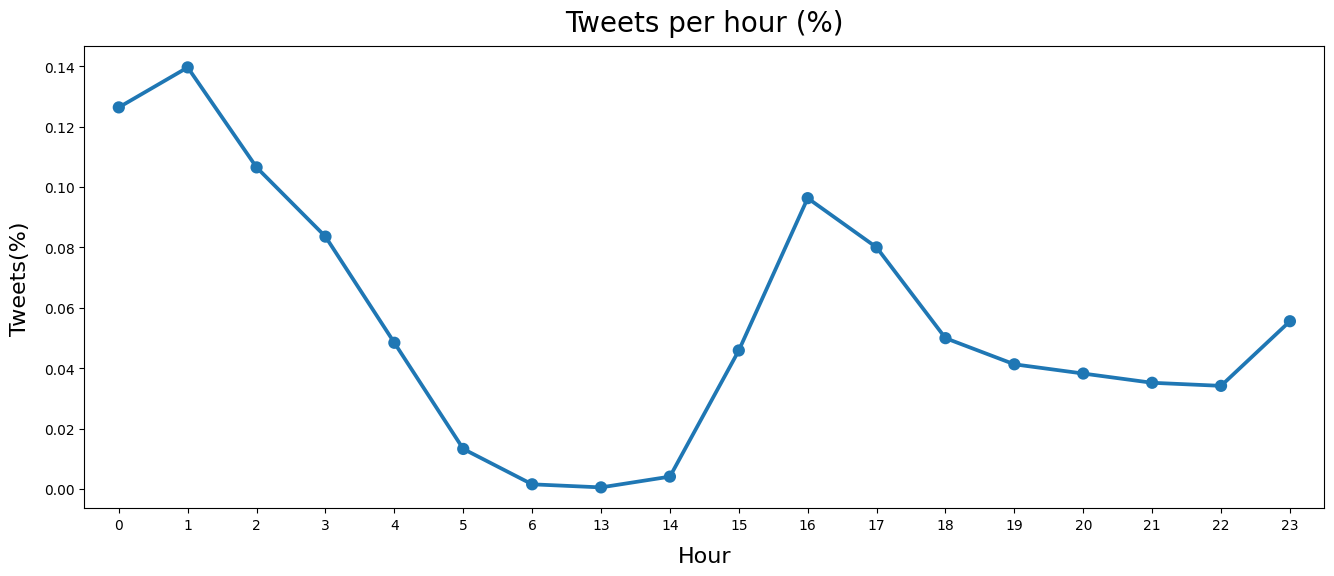

In [62]:
# Hours with most tweets
tweets_per_hour = (master_df['timestamp'].dt.hour.value_counts().sort_index())/master_df.shape[0]
# Point plot for hourly rides
sns.pointplot(x=tweets_per_hour.index, y=tweets_per_hour.values, color = base_color);
plt.title('Tweets per hour (%)', fontsize=20, y=1.015)
plt.xlabel('Hour', labelpad=10, fontsize=16)
plt.ylabel('Tweets(%)', labelpad=10, fontsize=16)
# Save to a file
plt.savefig('./img/tweets_per_hour.png')
# Show the plot
plt.show();

It seems the answer is yes. The account is especially active after midnight and in the afternoon, and dormant in the morning.

#### Tweets through the week

**Does the weekday matter for the account activity?**

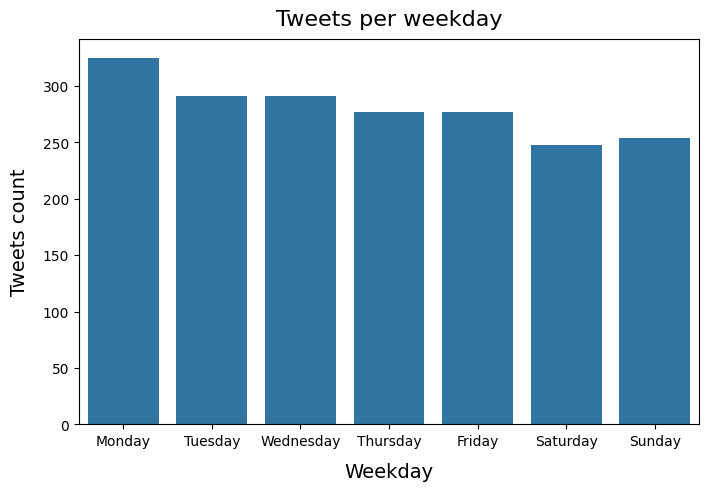

In [63]:
# Tweets number per weekday
rcParams['figure.figsize'] = 8,5
base_color = sns.color_palette()[0]
weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data=master_df, x=master_df['timestamp'].dt.day_name(), order=weekday, color=base_color)
plt.title('Tweets per weekday', fontsize=16, y=1.015)
plt.xlabel('Weekday', labelpad=10, fontsize=14)
plt.ylabel('Tweets count', labelpad=10, fontsize=14)
# Save to a file
plt.savefig('./img/tweets_per_weekday.png')
# Show the plot
plt.show();

It seems that the account is less active on weekends, and tweets more on Mondays.

### 6.2: Effect of rating on likes and retweets

**Does the rating matter? Does it affect likes and retweets?**

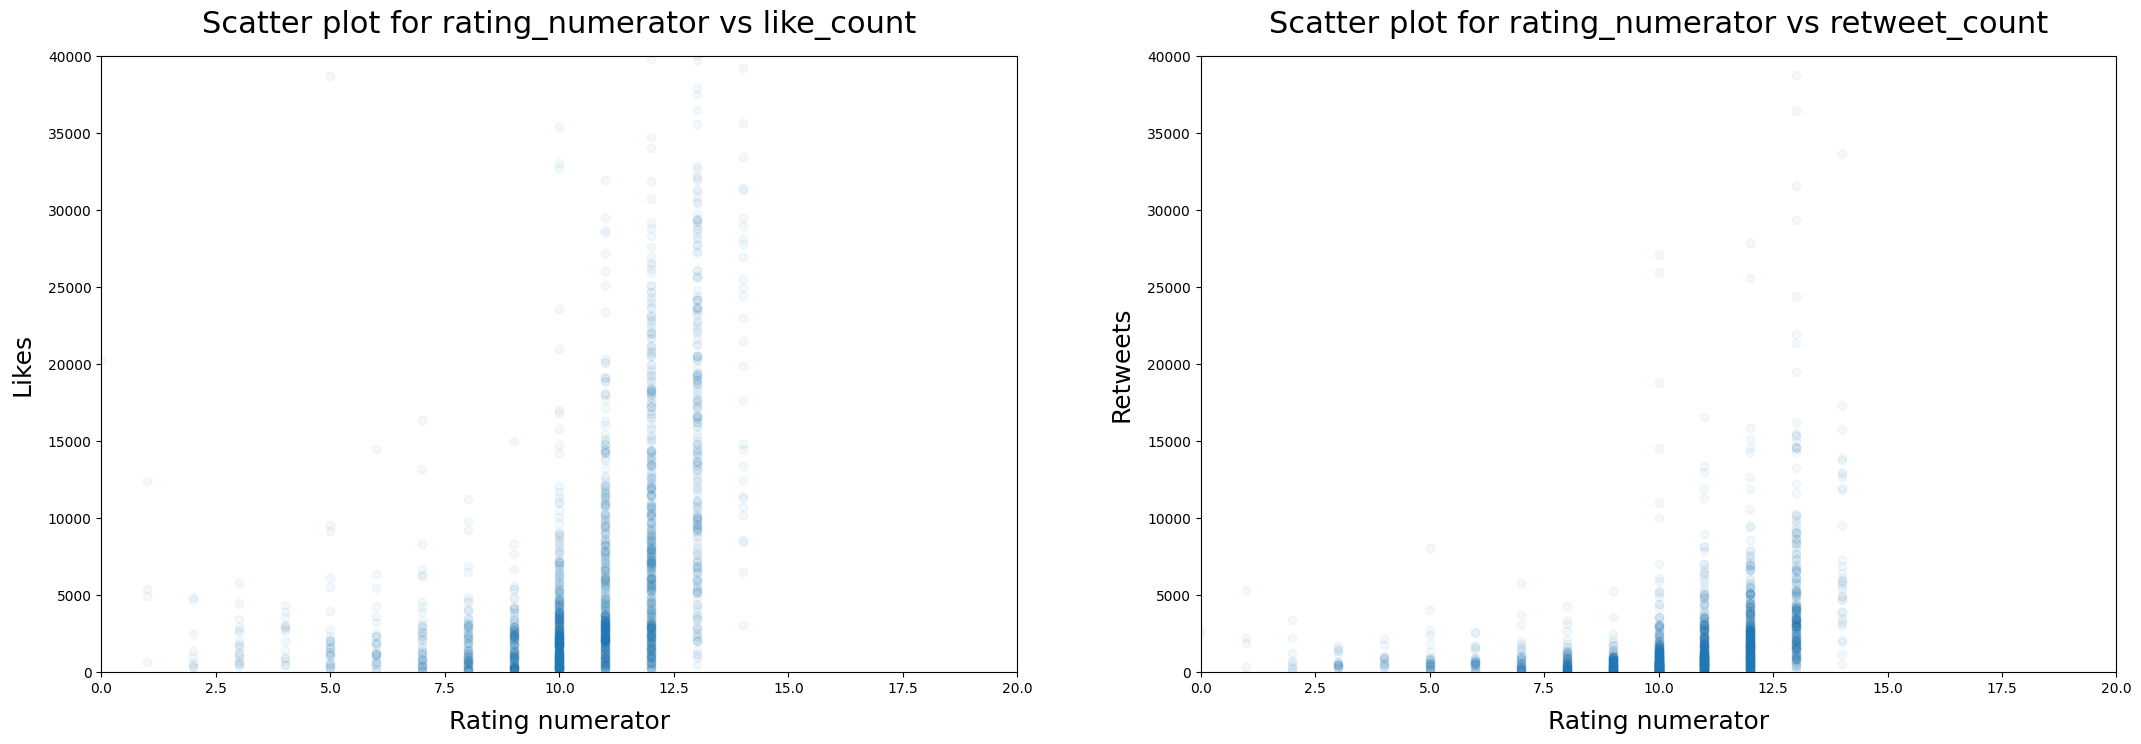

In [64]:
plt.figure(figsize = [26, 8])

# Scatter plot for rating_numerator vs like_count
plt.subplot(1, 2, 1)
plt.scatter(data = master_df, x ='rating_numerator' , y = 'like_count', alpha = 1/20)
plt.xlim((0,20))
plt.ylim((0,40000))
plt.title('Scatter plot for rating_numerator vs like_count', fontsize=22, y=1.025)
plt.xlabel('Rating numerator', labelpad=10, fontsize=18)
plt.ylabel('Likes', labelpad=10, fontsize=18)

# Scatter plot for rating_numerator vs retweet_count
plt.subplot(1, 2, 2)
plt.scatter(data = master_df, x ='rating_numerator' , y = 'retweet_count', alpha = 1/20)
plt.xlim((0,20))
plt.ylim((0,40000))
plt.title('Scatter plot for rating_numerator vs retweet_count', fontsize=22, y=1.025)
plt.xlabel('Rating numerator', labelpad=10, fontsize=18)
plt.ylabel('Retweets', labelpad=10, fontsize=18)

# Save to a file
plt.savefig('./img/rating_vs_likes_retweets.png')
# Show the plot
plt.show();

The answer is yes. There is a clear positive correlation between the rating numerator and number of likes and retweets.

### 6.3: Popular dog breeds

Finally, are there **popular dog breeds** in these funny tweets?

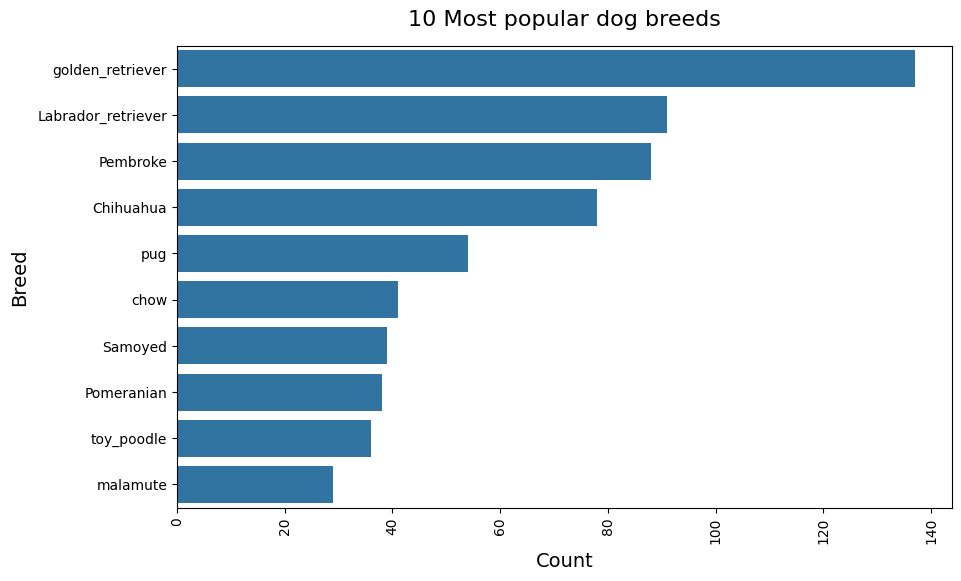

In [65]:
# 10 most popular dog breeds
popular_breeds = master_df.p1.value_counts()[:10]
rcParams['figure.figsize'] = 10,6
base_color = sns.color_palette()[0]
sns.barplot(x=popular_breeds, y=popular_breeds.index, color=base_color)
plt.title('10 Most popular dog breeds', fontsize=16, y=1.025)
plt.xlabel('Count', labelpad=6, fontsize=14)
plt.ylabel('Breed', labelpad=6, fontsize=14)
# Use xticks to rotate the category labels (not axes) counter-clockwise
plt.xticks(rotation=90)
# Save to a file
plt.savefig('./img/popular_breeds.png')
# Show the plot
plt.show();

It seems that the golden retriever is especially popular among dog lovers.

### **6.4:** Reflection

This report doesn't suggest any causality between variables and is limited to the scope of correlation. The dataset covers an outdated and limited time frame that is suitable only for educational purposes and should be updated for any practical application.